# bertchunker: default program

In [1]:
from default import *
import os, sys

/home/yiwenw/cmpt713/nlpclass-1241-g-Geranimus/hw2/bertchunker/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run the default solution on dev

In [2]:
chunker = FinetuneTagger(os.path.join('..', 'data', 'chunker'), modelsuffix='.pt')
decoder_output = chunker.decode(os.path.join('..', 'data', 'input', 'dev.txt'))

100%|██████████| 1027/1027 [00:19<00:00, 53.69it/s] 


Ignore the warnings from the transformers library. They are expected to occur.

## Evaluate the default output

In [3]:
flat_output = [ output for sent in decoder_output for output in sent ]
sys.path.append('..')
import conlleval
true_seqs = []
with open(os.path.join('..', 'data', 'reference', 'dev.out')) as r:
    for sent in conlleval.read_file(r):
        true_seqs += sent.split()
conlleval.evaluate(true_seqs, flat_output)

processed 23663 tokens with 11896 phrases; found: 11907 phrases; correct: 10773.
accuracy:  94.15%; (non-O)
accuracy:  94.43%; precision:  90.48%; recall:  90.56%; FB1:  90.52
             ADJP: precision:  72.65%; recall:  71.68%; FB1:  72.16  223
             ADVP: precision:  77.02%; recall:  74.12%; FB1:  75.54  383
            CONJP: precision:  71.43%; recall:  71.43%; FB1:  71.43  7
             INTJ: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
               NP: precision:  89.70%; recall:  91.98%; FB1:  90.83  6396
               PP: precision:  97.12%; recall:  94.06%; FB1:  95.57  2364
              PRT: precision:  79.07%; recall:  75.56%; FB1:  77.27  43
             SBAR: precision:  92.89%; recall:  77.22%; FB1:  84.33  197
               VP: precision:  89.84%; recall:  89.41%; FB1:  89.62  2293


(90.47619047619048, 90.55985205110962, 90.51800193252951)

## 1. Understanding Default Solution
## 1.1 Tokenizer
+ For the Tokenizer understanding, we used totorial from Transformer Notebooks: "How to fine-tune a model on token classification" [https://github.com/huggingface/notebooks/blob/main/examples/token_classification.ipynb]
The following codes test the outputs of a tokenized sentence.
+ Notice that the with the same set of settings in the default solution, some words are furtherly parsed into subwords in the test sentence.

In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

seq = ['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']
seq2 = ["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."]

input = tokenizer(seq,
		  is_split_into_words=True,
          add_special_tokens=False,
          return_tensors="pt")

input.encodings[0].tokens

['germany',
 "'",
 's',
 'representative',
 'to',
 'the',
 'european',
 'union',
 "'",
 's',
 'veterinary',
 'committee',
 'werner',
 'z',
 '##wing',
 '##mann',
 'said',
 'on',
 'wednesday',
 'consumers',
 'should',
 'buy',
 'sheep',
 '##me',
 '##at',
 'from',
 'countries',
 'other',
 'than',
 'britain',
 'until',
 'the',
 'scientific',
 'advice',
 'was',
 'clearer',
 '.']

In [23]:
from statistics import mode

original_lists = [
    ['a', 'b', 'c', 'a'],
    ['b', 'c', 'c', 'd'],
    ['a', 'b', 'b', 'b']
]
modes = [mode(l) for l in original_lists]

print(modes)

['a', 'c', 'b']


# 2. Improvements
## 2.1 Subword to word
In the default solution, when a word is furtherly parsed into multiple subwords, the argmax function use the first subword's predict class as the final prediction for the word. This is obviously not the best solution.

+ We use an ensemble result, that is we use the mode predict class as the final prediction for the word. With only this change, the dev score devrease a little bit from 0.918 to 0.913.

In [ ]:
def argmax(self, model, seq):
	output = [[] for _ in seq]
	with torch.no_grad():
		inputs = self.prepare_sequence(seq).to(device)
		tag_scores = model(inputs.input_ids).squeeze(0) # squeeze to remove batch dimension column
		# a word may have multiple subwords, thus the we use a list to record all subword prediction results
		for i, word_id in enumerate(inputs.encodings[0].word_ids):
			output[word_id].append(self.ix_to_tag[int(tag_scores[i].argmax(dim=0))])
	# TODO do a better subword-to-word resolution than the following line
	# Take the first subword and use the output tag for that subword for entire word
	# output = [item[0] for item in output]
	output = [mode(item) for item in output]
	assert len(seq) == len(output)
	return output 

### 2.2 Improve Classification Head
The default solution's classification head is a only one linear layer, which has very limit ability to map contextual states to labels. Thus, we use some other structures for potential improvements.

#### 2.2.1 Use Seperate Optimizers
The default solution use Adam and the same learning rate(e-5) for both the encoder and the classification head. But we know that for encoder, it is already a pre-trained model with further finetuning needed. In this case, the learning rate for the encoder should be relatively small. But for the classification head, it is a new network that needs to be trained from scratch. It is not reasonable for these two components to use the same set of optimzer and learning rate.
+ Since the perfect set of optimzer should be associate with a certain classification head structure, we do not test the model performance here. Instead we need to combine optimzer change with further classification head change.

In [ ]:
self.optimizers = [
            optim.Adam(
                list(self.encoder.parameters()),
                lr= 5e-5
            ),

            optim.SGD(
                 list(self.classification_head.parameters()),
                 lr = 0.1
            )
        ]

#### 2.2.1 FNN
+ We first try to use feedforward netword with multiple layers. The new FNN sturcture is shown in the below code. With a the non-linearity provided by the hidden layer, the classification head should have a better performance than the default result.

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(
            self,
            input_size = 768,
            hidden_size = 3072,
            output_size = 22,
            dropout_rate = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, input_size)
        self.classification_head = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        output = self.classification_head(x)
        return output

+ We still use Adam for encoder, SGD for FNN classification head, but we test different set of learning rate for training FNN. Below is our dev scores when using different learning rate.

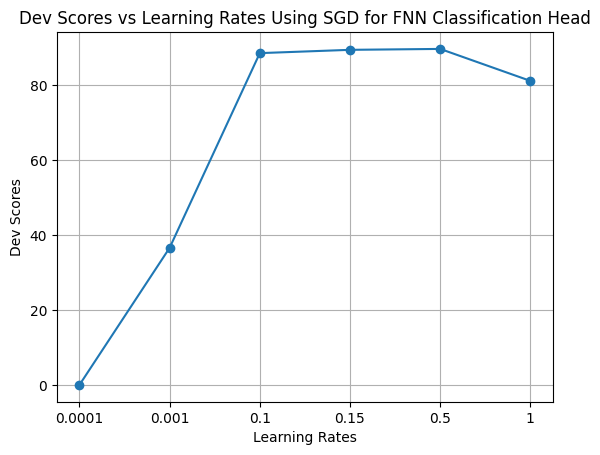

In [9]:
import matplotlib.pyplot as plt

lrs = [0.0001, 0.001, 0.1, 0.15, 0.5, 1]
dev_scores = [0, 36.5913, 88.5474, 89.4268, 89.6699, 81.1407]

num_points = len(lrs)
x_values = range(1, num_points + 1)

plt.plot(x_values, dev_scores, marker='o', linestyle='-')

plt.xlabel('Learning Rates')
plt.ylabel('Dev Scores')
plt.title('Dev Scores vs Learning Rates Using SGD for FNN Classification Head')
plt.xticks(x_values, lrs)
plt.grid(True)

plt.show()


+ Then we use Adam for both encoder and FNN classification head but test different learning rate for training FNN. 

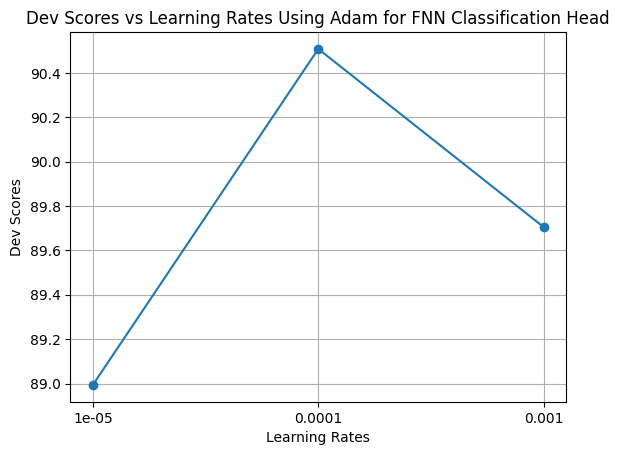

In [10]:
lrs = [0.00001, 0.0001, 0.001]
dev_scores = [88.9936, 90.5082, 89.7048]

# Define the number of data points
num_points = len(lrs)

# Generate a sequence of integers for x-axis
x_values = range(1, num_points + 1)

plt.plot(x_values, dev_scores, marker='o', linestyle='-')

plt.xlabel('Learning Rates')
plt.ylabel('Dev Scores')
plt.title('Dev Scores vs Learning Rates Using Adam for FNN Classification Head')
plt.xticks(x_values, lrs)  # Set ticks for each data point with corresponding learning rate
plt.grid(True)

plt.show()

## 2.3 Augmenting Training Dataset
In default solution, the distribution of training data and testing data is different. Training dataset does not contain any mispelling words, or noise. To make our model more robust, we need to enhance our training dataset so that our model is trained to deal with such mispelling.

+ We randomly introduce 3 kind of noise into out training data in character level. 

In [27]:
from bertchunker import *
chunker = FinetuneTagger('../data/chunker', '.pt', 'distilbert-base-uncased')
print(chunker.model_str())

TransformerModel(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin